In [1]:
import pandas as pd
import numpy as np

import seaborn as sns
from matplotlib import pyplot as plt
from matplotlib.lines import Line2D

StatementMeta(, 14624e3d-cdcd-4f96-ad51-5e99e1270d24, 3, Finished, Available, Finished)

## Datasets Summary

| Dataset                                     | Data                                                            | Unit     | Period Start | Period End | Frequency | Availability                                                                                                                                  |
| ------------------------------------------- | --------------------------------------------------------------- | -------- | ------------ | ---------- | --------- | --------------------------------------------------------------------------------------------------------------------------------------------- |
| SA Crime Record                             | - Number of Records                                             | record   | July 2010    | March 2025 | Daily     | [Data SA](https://data.sa.gov.au/data/dataset/crime-statistics)                                                                               |
| Median Price of Established House Transfers | - Adelaide Price<br>- Rest of SA Price                          | $1000    | March 2002   | March 2025 | Quarterly | [Australian Bureau of Statistics](https://www.abs.gov.au/statistics/economy/price-indexes-and-inflation/total-value-dwellings/latest-release) |
| Australian Cash Rate Target                 | - CRT                                                           | %        | Aug 1990     | May 2025   | Monthly   | [Reserve Bank of Australia](https://www.rba.gov.au/statistics/cash-rate/)                                                                     |
| Consumer Price Index (CPI)                  | - Adelaide<br>- Australia                                       | %        | April 2001   | April 2025 | Quarterly | [City of Adelaide](https://economy.id.com.au/adelaide/consumer-price-index)                                                                   |
| Unemployment Rate                           | - City of Adelaide<br>- Greater Adelaide<br>- SA<br>- Australia | %        | Dec 2010     | Dec 2024   | Quarterly | [City of Adelaide](https://economy.id.com.au/adelaide/unemployment)                                                                           |
| SA Gross Regional Product                   | - GRP                                                           | $million | 2001         | 2024       | Annually  | [City of Adelaide](https://economy.id.com.au/adelaide/gross-regional-product)                                                                 |



In [2]:
crime_by_month_df = spark.sql(
    """
    SELECT
        YEAR(ReportedDate) AS Year,
        MONTH(ReportedDate) AS Month,
        SUM(Count) AS NumberRecords
    FROM
        fact_record_gold
    GROUP BY
        YEAR(ReportedDate), MONTH(ReportedDate)
    ORDER BY
        Year, Month;
    """
).toPandas()

StatementMeta(, 14624e3d-cdcd-4f96-ad51-5e99e1270d24, 4, Finished, Available, Finished)

In [3]:
crime_by_quarter_df = spark.sql(
    """
    SELECT
        YEAR(ReportedDate) AS Year,
        Quarter(ReportedDate) AS Quarter,
        SUM(Count) AS NumberRecords
    FROM
        fact_record_gold
    GROUP BY
        YEAR(ReportedDate), Quarter(ReportedDate)
    ORDER BY
        Year, Quarter;
    """
).toPandas()

StatementMeta(, 14624e3d-cdcd-4f96-ad51-5e99e1270d24, 5, Finished, Available, Finished)

In [4]:
crime_by_year_df = spark.sql(
    """
    SELECT
        YEAR(ReportedDate) AS Year,
        SUM(Count) AS NumberRecords
    FROM
        fact_record_gold
    GROUP BY
        YEAR(ReportedDate)
    ORDER BY
        Year;
    """
).toPandas()

StatementMeta(, 14624e3d-cdcd-4f96-ad51-5e99e1270d24, 6, Finished, Available, Finished)

In [5]:
%run sa_economic_data_loader

StatementMeta(, 14624e3d-cdcd-4f96-ad51-5e99e1270d24, 18, Finished, Available, Finished)

## SA Crime Record vs. CRT (monthly, July 2010 to March 2025)

In [6]:
filtered_cpi_df = crt_df.loc['2010-07': '2025-03']

StatementMeta(, 14624e3d-cdcd-4f96-ad51-5e99e1270d24, 19, Finished, Available, Finished)

In [7]:
concated = np.concatenate([crime_by_month_df.to_numpy()[:, 2:], filtered_cpi_df.to_numpy()], axis=1)
corr_mat = np.corrcoef(concated.T)

StatementMeta(, 14624e3d-cdcd-4f96-ad51-5e99e1270d24, 20, Finished, Available, Finished)

StatementMeta(, 14624e3d-cdcd-4f96-ad51-5e99e1270d24, 21, Finished, Available, Finished)

<Axes: >

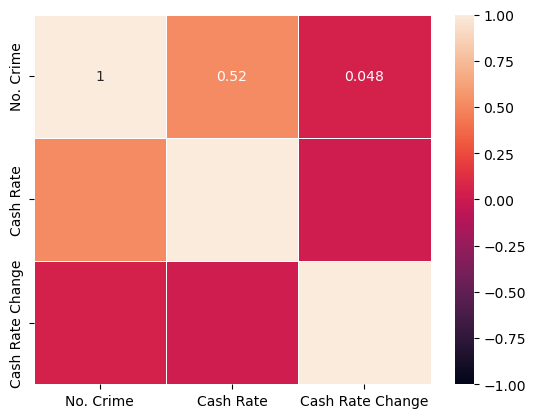

In [8]:
labels = ['No. Crime', 'Cash Rate', 'Cash Rate Change']
sns.heatmap(corr_mat, linewidth=0.5, xticklabels=labels, yticklabels=labels, annot=True, vmax=1.0, vmin=-1.0)

In [9]:
display_mat = np.concatenate([crime_by_month_df.to_numpy()[:,2:], filtered_cpi_df.to_numpy()], axis=1)
display_df = pd.DataFrame(display_mat, columns=['Number Records', 'CRT', 'CRT Change'])
display_df['Date'] = filtered_cpi_df.index.astype(str)

StatementMeta(, 14624e3d-cdcd-4f96-ad51-5e99e1270d24, 22, Finished, Available, Finished)

StatementMeta(, 14624e3d-cdcd-4f96-ad51-5e99e1270d24, 23, Finished, Available, Finished)

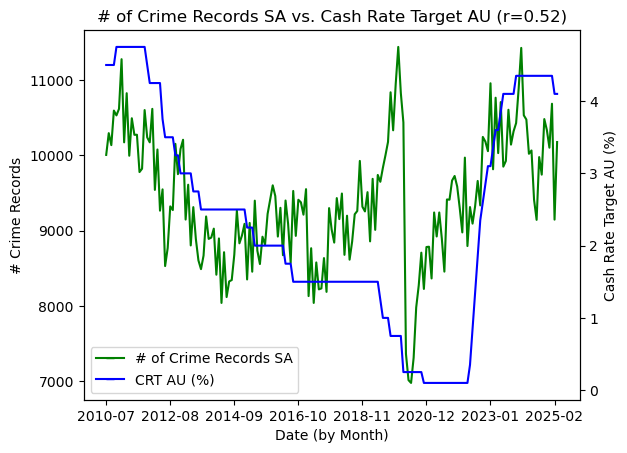

In [10]:
ax1 = display_df.plot(x='Date', y='Number Records', color='g', legend=False, ylabel='# Crime Records')
display_df.plot(x='Date', y='CRT', color='b', ax=ax1.twinx(), legend=False, ylabel='Cash Rate Target AU (%)')

ax1.set_title('# of Crime Records SA vs. Cash Rate Target AU (r=0.52)')
ax1.set_xlabel(xlabel='Date (by Month)')
ax1.legend(handles=[Line2D([], [], marker='_', color='g', label='# of Crime Records SA'), Line2D([], [], marker='_', color='b', label='CRT AU (%)')])

The figure indicates a moderate positive correlation between the number of criminals and the cash rate. We can observe there was a slow CRT cut right before the Covid, meanwhile the number of criminals was surging. With the ease of Covid, the number of criminals was going back to the level of pre-covid, along with the increasing of CRT.

## SA Crime Record vs. Housing Price, CPI, Unemployment rate (Quarterly, December 2010 to December 2024)

In [11]:
filtered_housing_price_df = sa_housing_price_df.loc['2010-12': '2024-12']
filtered_cpi_df = cpi_df.loc['2011-01': '2025-01']
filtered_unemploy_df = unemploy_df.loc['2010-12': '2024-12']

StatementMeta(, 14624e3d-cdcd-4f96-ad51-5e99e1270d24, 24, Finished, Available, Finished)

In [12]:
concated = np.concatenate(
    [
        crime_by_quarter_df.to_numpy()[1:-1, 2:],
        filtered_housing_price_df.to_numpy(),
        filtered_cpi_df.to_numpy()[:, :-1],
        filtered_unemploy_df.to_numpy()[:, 1:]
    ], axis=1)
corr_mat = np.corrcoef(concated.T)

StatementMeta(, 14624e3d-cdcd-4f96-ad51-5e99e1270d24, 25, Finished, Available, Finished)

StatementMeta(, 14624e3d-cdcd-4f96-ad51-5e99e1270d24, 26, Finished, Available, Finished)

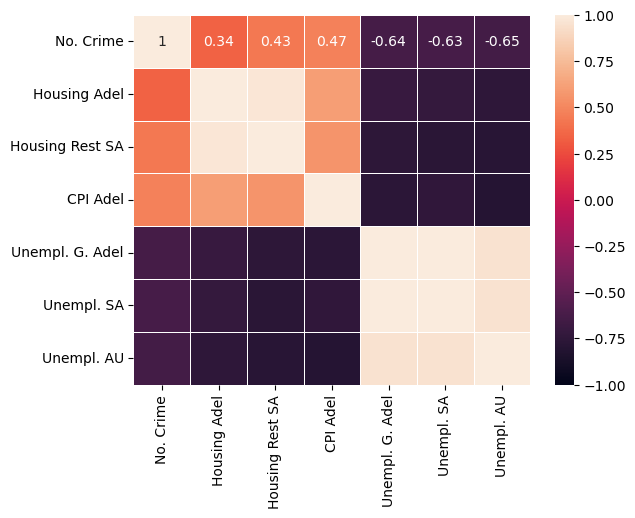

In [13]:
labels = ['No. Crime', 'Housing Adel', 'Housing Rest SA', 'CPI Adel', 'Unempl. G. Adel', 'Unempl. SA', 'Unempl. AU']
ax = sns.heatmap(corr_mat, linewidth=0.5, xticklabels=labels, yticklabels=labels, annot=True, vmax=1.0, vmin=-1.0)

In [14]:
display_mat = np.concatenate([crime_by_quarter_df.to_numpy()[1:-1, 2:], filtered_cpi_df.to_numpy()[:, :-1]], axis=1)
display_df = pd.DataFrame(display_mat, columns=['Number Records', 'Adel. CPI'])
display_df['Date'] = filtered_housing_price_df.index.astype(str)

StatementMeta(, 14624e3d-cdcd-4f96-ad51-5e99e1270d24, 27, Finished, Available, Finished)

StatementMeta(, 14624e3d-cdcd-4f96-ad51-5e99e1270d24, 28, Finished, Available, Finished)

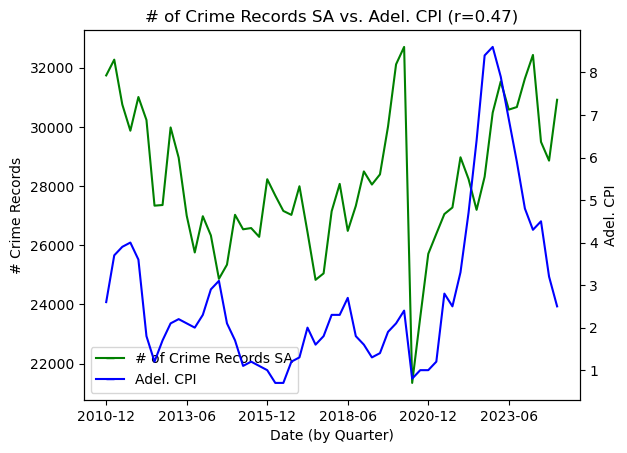

In [15]:
ax1 = display_df.plot(x='Date', y='Number Records', color='g', legend=False, ylabel='# Crime Records')
display_df.plot(x='Date', y='Adel. CPI', color='b', ax=ax1.twinx(), legend=False, ylabel='Adel. CPI')

ax1.set_title('# of Crime Records SA vs. Adel. CPI (r=0.47)')
ax1.set_xlabel(xlabel='Date (by Quarter)')
ax1.legend(handles=[Line2D([], [], marker='_', color='g', label='# of Crime Records SA'), Line2D([], [], marker='_', color='b', label='Adel. CPI')])

There is a moderate positive correlation between the CPI in Adelaide and the number of criminal records. 

In [16]:
display_mat = np.concatenate([crime_by_quarter_df.to_numpy()[1:-1, 2:], filtered_unemploy_df.to_numpy()[:, 1:]], axis=1)
display_df = pd.DataFrame(display_mat, columns=['Number Records', 'Unempl. G. Adel', 'Unempl. SA', 'Unempl. AU'])
display_df['Date'] = filtered_housing_price_df.index.astype(str)

StatementMeta(, 14624e3d-cdcd-4f96-ad51-5e99e1270d24, 29, Finished, Available, Finished)

StatementMeta(, 14624e3d-cdcd-4f96-ad51-5e99e1270d24, 30, Finished, Available, Finished)

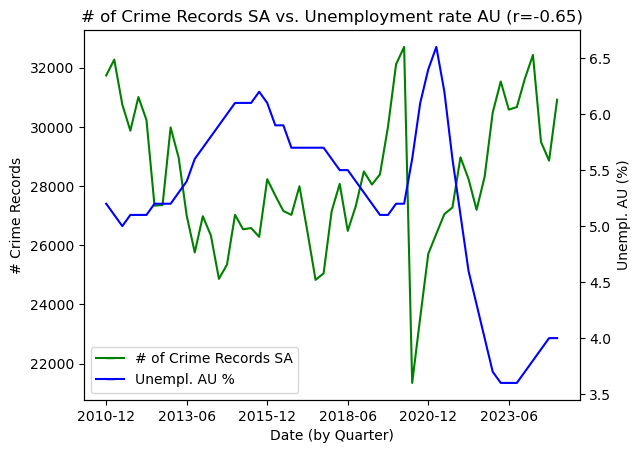

In [17]:
ax1 = display_df.plot(x='Date', y='Number Records', color='g', legend=False, ylabel='# Crime Records')
display_df.plot(x='Date', y='Unempl. AU', color='b', ax=ax1.twinx(), legend=False, ylabel='Unempl. AU (%)')

ax1.set_title('# of Crime Records SA vs. Unemployment rate AU (r=-0.65)')
ax1.set_xlabel(xlabel='Date (by Quarter)')
ax1.legend(handles=[Line2D([], [], marker='_', color='g', label='# of Crime Records SA'), Line2D([], [], marker='_', color='b', label='Unempl. AU %')])

It does show a strong negative correlation between the unemployment rate (AU) and the number of criminals ($r=-0.65$) in South Australia. Potential explanations include:

- Covid-19 Lockdown: the criminal rate reached at a very low level, however, the lockdown also caused the surge of unemployment (retail worker, hospitality, etc)
- Income inequality.

## SA Crime Record vs. GRP (Annual, 2010 to 2024)

In [18]:
crime_by_year_df

concated = np.concatenate(
    [
        crime_by_year_df.to_numpy()[:, 1:],
        grp_df.to_numpy()[8:,],
    ], axis=1)
corr_mat = np.corrcoef(concated.T)

StatementMeta(, 14624e3d-cdcd-4f96-ad51-5e99e1270d24, 31, Finished, Available, Finished)

StatementMeta(, 14624e3d-cdcd-4f96-ad51-5e99e1270d24, 32, Finished, Available, Finished)

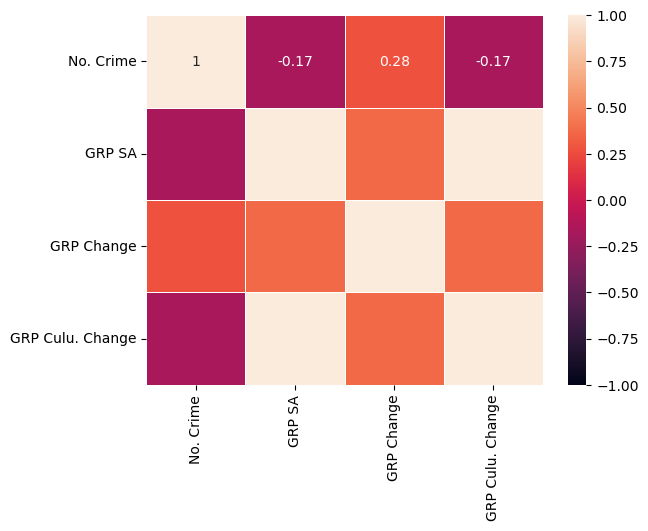

In [19]:
labels = ['No. Crime', 'GRP SA', 'GRP Change', 'GRP Culu. Change']
ax = sns.heatmap(corr_mat, linewidth=0.5, xticklabels=labels, yticklabels=labels, annot=True, vmax=1.0, vmin=-1.0)

In [20]:
display_mat = np.concatenate([crime_by_year_df.to_numpy(), grp_df.to_numpy()[8:, 1:2]], axis=1)
display_df = pd.DataFrame(display_mat, columns=['Year', 'Number Records', 'SA GRP Change'])

StatementMeta(, 14624e3d-cdcd-4f96-ad51-5e99e1270d24, 33, Finished, Available, Finished)

StatementMeta(, 14624e3d-cdcd-4f96-ad51-5e99e1270d24, 34, Finished, Available, Finished)

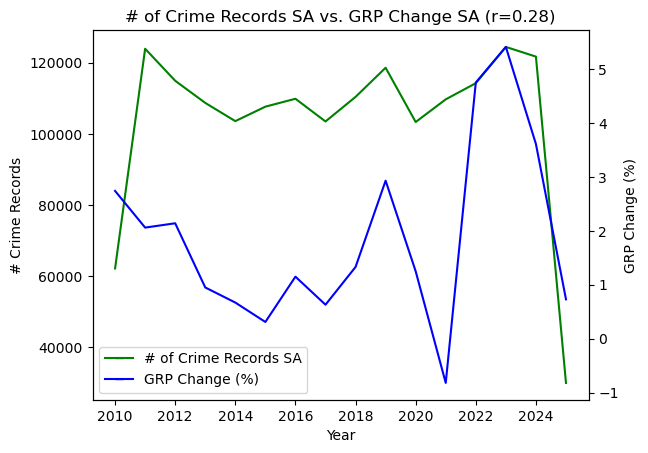

In [21]:
ax1 = display_df.plot(x='Year', y='Number Records', color='g', legend=False, ylabel='# Crime Records')
display_df.plot(x='Year', y='SA GRP Change', color='b', ax=ax1.twinx(), legend=False, ylabel='GRP Change (%)')

ax1.set_title('# of Crime Records SA vs. GRP Change SA (r=0.28)')
ax1.legend(handles=[Line2D([], [], marker='_', color='g', label='# of Crime Records SA'), Line2D([], [], marker='_', color='b', label='GRP Change (%)')])